In [1]:
import pandas as pd
import numpy as np
from common import collect_results, normalize_region_name
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
ROOT = Path("ycsb")

def get_matcher(prefix):
    def matcher(p: Path):   
        import re
        pattern = re.compile(prefix + r"-hot(\d+)-(\w)-mr(\d+)-([\d-]+)")
        match = pattern.match(p.name)
        if not match:
            return None

        print("Found result:", p.name)
        hot = int(match.group(1))
        return {
            "hot": 1000000 if hot == 0 else hot,
            "workload": str(match.group(2)),
            "mr": int(match.group(3)),
            "suffix": str(match.group(4)),
        }
    
    return matcher

# Throughput & Abort Rate


In [3]:
SYSTEMS = ["sunstorm", "aurora", "yugabyte"]
HOTS = [100000, 10000, 1000]
RENEW_CACHE = False

sunstorm_matcher = get_matcher("ycsb-throughput-sunstorm")
sunstorm_throughput_df = collect_results(
    ROOT / "throughput-sunstorm",
    sunstorm_matcher,
    RENEW_CACHE,
)
sunstorm_throughput_df["system"] = "sunstorm"

aurora_matcher = get_matcher("ycsb-throughput-aurora")
aurora_throughput_df = collect_results(
    ROOT / "throughput-aurora",
    aurora_matcher,
    RENEW_CACHE,
)
aurora_throughput_df["system"] = "aurora"

yugabyte_matcher = get_matcher("ycsb-throughput-yugabyte")
yugabyte_throughput_df = collect_results(
    ROOT / "throughput-yugabyte",
    yugabyte_matcher,
    RENEW_CACHE,
)
yugabyte_throughput_df["system"] = "yugabyte"

## Throughput

In [4]:
throughput_df = pd.concat([
    sunstorm_throughput_df,
    aurora_throughput_df,
    yugabyte_throughput_df,
])
throughput_df["HOT"] = 1 / throughput_df["hot"]
normalize_region_name(throughput_df)
throughput_df

,path,region,hot,workload,mr,suffix,rejected,rejected.WorkloadF1,rejected.WorkloadF2,rejected.WorkloadF3,...,ood_tuple,other_aborts,deadlock,throughput,throughput.WorkloadF3,throughput.WorkloadF1,unexpected.WorkloadF2,unexpected.WorkloadF3,system,HOT
0,ycsb/throughput-sunstorm/ycsb-throughput-sunst...,1-us-east-1-0,100000,F,10,20240430-153607,1064,560,419.0,85.0,...,465,598,0,5208.286832,74.0,4698.3,NaN,NaN,sunstorm,0.00001
1,ycsb/throughput-sunstorm/ycsb-throughput-sunst...,2-eu-west-1-0,100000,F,10,20240430-153607,1064,584,388.0,92.0,...,445,617,0,4575.755323,63.4,4103.3,NaN,NaN,sunstorm,0.00001
2,ycsb/throughput-sunstorm/ycsb-throughput-sunst...,3-ap-northeast-1-0,100000,F,10,20240430-153607,1174,560,507.0,107.0,...,569,598,0,3934.176440,55.4,3535.2,NaN,NaN,sunstorm,0.00001
3,ycsb/throughput-sunstorm/ycsb-throughput-sunst...,1-us-east-1-0,10000,F,50,20240430-161215,3402,502,2246.0,654.0,...,1299,1032,0,1726.062443,123.4,856.2,NaN,NaN,sunstorm,0.00010
4,ycsb/throughput-sunstorm/ycsb-throughput-sunst...,2-eu-west-1-0,10000,F,50,20240430-161215,3229,477,2112.0,640.0,...,1374,959,0,1434.814092,100.4,719.0,NaN,NaN,sunstorm,0.00010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,ycsb/throughput-yugabyte/ycsb-throughput-yugab...,2-eu-west-1-0,1000,F,0,20240501-110250,45280,45280,NaN,NaN,...,0,45280,0,1863.080996,NaN,2361.2,NaN,NaN,yugabyte,0.00100
56,ycsb/throughput-yugabyte/ycsb-throughput-yugab...,3-ap-northeast-1-0,1000,F,0,20240501-110250,37823,37823,NaN,NaN,...,0,37823,0,1907.240574,NaN,2326.4,NaN,NaN,yugabyte,0.00100
57,ycsb/throughput-yugabyte/ycsb-throughput-yugab...,1-us-east-1-0,1000,F,5,20240501-110250,41530,35286,5246.0,998.0,...,0,41530,0,1725.680609,15.5,2077.5,NaN,NaN,yugabyte,0.00100
58,ycsb/throughput-yugabyte/ycsb-throughput-yugab...,2-eu-west-1-0,1000,F,5,20240501-110250,30664,24826,4950.0,888.0,...,0,30664,0,1642.895334,13.1,1853.5,NaN,NaN,yugabyte,0.00100


## Abort Rate

In [5]:
error_columns = ['ood_index_page', 'ood_tuple', 'other_aborts'] 
error_df = throughput_df.groupby(["hot", "system", "mr"]).sum()[error_columns + ['ood_table', 'deadlock', 'completed']]
error_df["ood_index_page_pct"] = error_df["ood_index_page"] / error_df["completed"] * 100
error_df["ood_table_pct"] = error_df["ood_table"] / error_df["completed"] * 100
error_df["ood_tuple_pct"] = error_df["ood_tuple"] / error_df["completed"] * 100
error_df["other_aborts_pct"] = error_df["other_aborts"] / error_df["completed"] * 100
error_df["deadlock_pct"] = error_df["deadlock"] / error_df["completed"] * 100
error_df["pct"] = error_df["deadlock_pct"] + error_df["ood_index_page_pct"] + error_df["ood_table_pct"] + error_df["ood_tuple_pct"] + error_df["other_aborts_pct"]
error_df.loc[(1000, "sunstorm",)]

,ood_index_page,ood_tuple,other_aborts,ood_table,deadlock,completed,ood_index_page_pct,ood_table_pct,ood_tuple_pct,other_aborts_pct,deadlock_pct,pct
mr,,,,,,,,,,,,
0,0,0,45788,0,0,3065815,0.000000,0.0,0.000000,1.493502,0.0,1.493502
5,10076,30026,37368,0,0,1289886,0.781154,0.0,2.327803,2.897000,0.0,6.005957
10,20618,23311,27495,0,0,797407,2.585631,0.0,2.923350,3.448051,0.0,8.957032
15,19878,20862,23318,0,0,602765,3.297803,0.0,3.461050,3.868506,0.0,10.627359
50,80247,10243,18161,0,0,212138,37.827735,0.0,4.828461,8.560937,0.0,51.217132


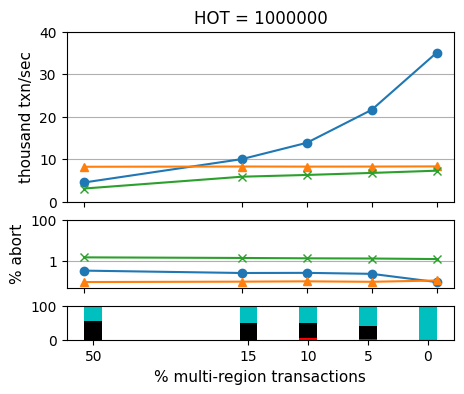

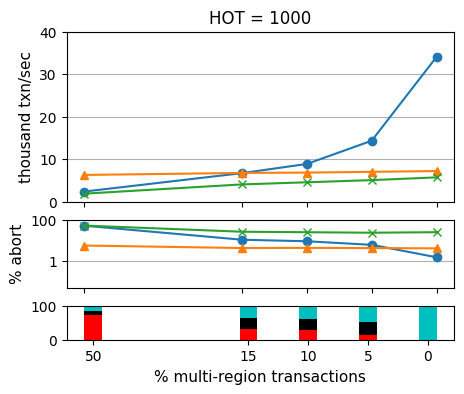

In [59]:
from matplotlib.ticker import ScalarFormatter

plt.rc('axes', labelsize=11) 
plt.rc('legend', fontsize=11)

xticks = [0, 5, 10, 15, 50]
xticklabels = [0, 5, 10, 15, 50]
legend_handles_labels = ([], [])
abort_colors = ["r", "k", "c"]

for hot in [1000000, 1000]:
    fig, axes = plt.subplots(
        3, 1, 
        figsize=(5, 4),
        sharex=False,
        gridspec_kw={"height_ratios": [5, 2, 1]},
    )
    hot_throughput_df = throughput_df[throughput_df.hot == hot]
    pivoted = hot_throughput_df.pivot_table(
        index=["mr"], columns=["system"], values="throughput", aggfunc="sum"
    ).set_index(np.array(xticks)) / 1000
    pivoted[SYSTEMS].plot(
        ax=axes[0],
        title=f"HOT = {hot}",
        ylabel="thousand txn/sec",
        style=["o-", "^-", "x-"],
        ylim=(0, 40),
        rot=0,
        legend=False,
    )
    axes[0].set_xscale("symlog", linthresh=20)
    axes[0].set_xticks(xticks)
    axes[0].set_xticklabels([])
    axes[0].margins(x=0.05)
    axes[0].grid(axis="y")
    # axes[0].legend(title="", ncol=3, handletextpad=0.3)
    axes[0].invert_xaxis()
    legend_handles_labels = axes[0].get_legend_handles_labels()

    error_df.unstack(level=1)["pct"].loc[hot][SYSTEMS]\
        .set_index(np.array(xticks))\
        .plot(
            ax=axes[1],
            ylabel="% abort",
            style=["o-", "^-", "x-"],
            ylim=(0.05, 100),
            logy=True,
            rot=0,
            legend=False,
        )

    axes[1].set_xscale("symlog", linthresh=20)
    axes[1].set_xticks(xticks)
    axes[1].set_xticklabels([])
    axes[1].margins(x=0.05)
    axes[1].grid(axis="y")
    axes[1].invert_xaxis()
    axes[1].get_yaxis().set_major_formatter(ScalarFormatter())

    xticks_hack = [0, 5, 10, 15, 28]
    sunstorm_error_df = error_df.loc[(hot, "sunstorm",)].copy()
    error_columns_pct = [f"{col}_pct" for col in error_columns]
    bottom = None
    for col, color in zip(error_columns_pct, abort_colors):
        error = sunstorm_error_df[col] / sunstorm_error_df["pct"] * 100
        axes[2].bar(
            xticks_hack,
            error,
            bottom=bottom,
            label=col,
            width=1.5,
            facecolor=color,
        )
        if bottom is None:
            bottom = error
        else:
            bottom += error
    axes[2].set_ylim(0, 100)
    axes[2].margins(x=0.05)
    axes[2].set_xticks(xticks_hack)
    axes[2].set_xticklabels(xticklabels)
    axes[2].set_xlabel("% multi-region transactions")
    axes[2].invert_xaxis()

    plt.savefig(f"output/micro-throughput-hot{hot}.pdf", bbox_inches="tight")


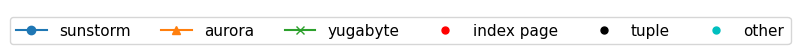

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(0.1, 0.1)) 
ax.set_axis_off() 
patches = [
    plt.plot(
        [],[], 
        marker="o", 
        ms=5,
        ls="",
        color=color,
    )[0]
    for color in abort_colors
]
abort_mapping = {
    "ood_index_page": "index page",
    "ood_tuple": "tuple",
    "other_aborts": "other",
}
labels = [abort_mapping[col] for col in error_columns]
ax.legend(legend_handles_labels[0] + patches, legend_handles_labels[1] + labels, ncol=6) 
fig.savefig("output/legend.pdf", bbox_inches="tight")

# Latency


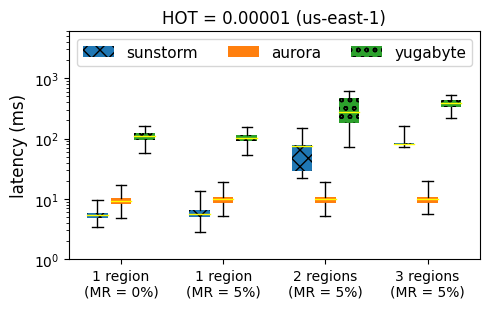

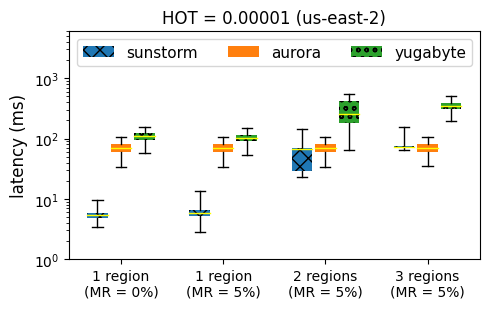

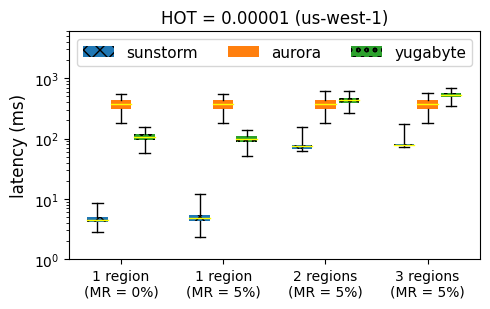

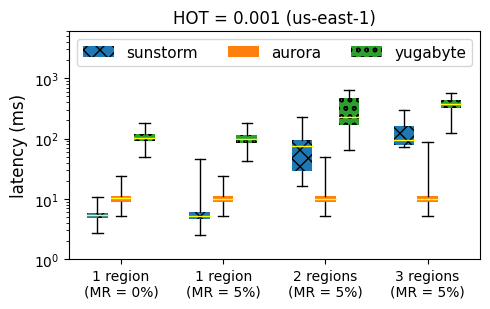

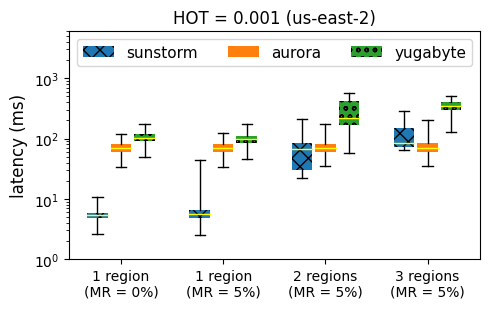

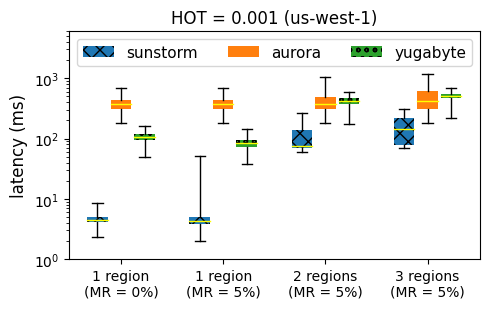

In [31]:
plt.rc('axes', labelsize=12) 
plt.rc('legend', fontsize=11)

labels = [
    "1 region\n(MR = 0%)",
    "1 region\n(MR = 5%)",
    "2 regions\n(MR = 5%)",
    "3 regions\n(MR = 5%)",
]
ticks = np.arange(len(labels))

width = 0.46

def to_box(df, n):
    return {
        'whislo': df[f"p0.WorkloadF{n}"].iloc[0],
        'q1': df[f"p25.WorkloadF{n}"].iloc[0],
        'med': df[f"p50.WorkloadF{n}"].iloc[0],
        'q3': df[f"p75.WorkloadF{n}"].iloc[0],
        'whishi': df[f"p99.WorkloadF{n}"].iloc[0],
        'fliers': []
    }

legends = []
patterns = ["xx", "", "oo"]

for hot in [100000, 1000]:
    hot_df = throughput_df[throughput_df.hot == hot]
    hot_label = f"{1/hot:.5f}".rstrip("0")
    for region in ["1-us-east-1", "2-us-east-2", "3-us-west-1"]:
        region_df = hot_df[hot_df.region.str.startswith(region)]

        fig, ax = plt.subplots(figsize=(5, 3.2))
        for i, system in enumerate(SYSTEMS):
            system_df = region_df[region_df.system == system]
            boxes = [
                to_box(system_df[system_df.mr == 0], 1),
                to_box(system_df[system_df.mr == 5], 1),
                to_box(system_df[system_df.mr == 5], 2),
                to_box(system_df[system_df.mr == 5], 3),
            ]
            comps = ax.bxp(
                boxes,
                positions=ticks - width / 2 + i * width / (len(SYSTEMS) - 1),
                showfliers=False,
                manage_ticks=False,
                patch_artist=True,
                widths=0.2,
                boxprops={
                    "facecolor": f"C{i}",
                    "linewidth": 0,
                    "hatch": patterns[i],
                },
                medianprops={
                    "color": "yellow",
                    "linewidth": 1,
                },
            )
            legends.append(comps["boxes"][0])

        ax.legend(legends, SYSTEMS, ncol=3)

        ax.set_xticks(labels=labels, ticks=ticks)
        ax.set_yscale("log")
        ax.set_ylim(1, 6000)
        ax.set_ylabel("latency (ms)")
        # ax.grid()

        ax.set_title(f"HOT = {hot_label} ({region[2:]})")
        fig.tight_layout()
        fig.savefig(f"output/micro-latency-{region[2:]}-hot{hot}.pdf", bbox_inches="tight")


In [11]:
def plot_latency(mr, hot):
    # Remove the "-0" suffix in region name
    regions = sorted([r for r in set(throughput_df.region.unique()) if not r.endswith("-0")])
    for system in throughput_df.system.unique():
        fig, axes = plt.subplots(1, len(regions), figsize=(20, 4), sharey=True)
        fig.suptitle(f"{system}, hot = {hot}, mr = {mr}%")
        workload_df = throughput_df[
            (throughput_df.system == system)
            & (throughput_df.mr == mr)
            & (throughput_df.hot == hot)
        ]
        # Plot for each region
        for i, region in enumerate(regions):
            region_df = workload_df[workload_df.region.str.startswith(region)]
            if region_df.empty:
                continue
            # Seperate the tran sactions by the number of regions they access
            max_nregion = 3
            index = range(1, max_nregion + 1)
            nregion_latency_df = {
                "p0": [region_df[f"p0.WorkloadF{n}"].iloc[0] for n in index],
                "p25": [region_df[f"p25.WorkloadF{n}"].iloc[0] for n in index],
                "p50": [region_df[f"p50.WorkloadF{n}"].iloc[0] for n in index],
                "p75": [region_df[f"p75.WorkloadF{n}"].iloc[0] for n in index],
                "p95": [region_df[f"p95.WorkloadF{n}"].iloc[0] for n in index],
                "p99": [region_df[f"p99.WorkloadF{n}"].iloc[0] for n in index],
            }
            pd.DataFrame(nregion_latency_df, index=index).plot.bar(
                title=region,
                ylabel="latency (ms)",
                ax=axes[i],
                rot=0,
                ylim=(1, 1200),
                logy=True,
            )
            axes[i].set_xlabel("number of regions")
            axes[i].grid(axis="y")
        plt.tight_layout()

In [ ]:
plot_latency(0, 1000000)

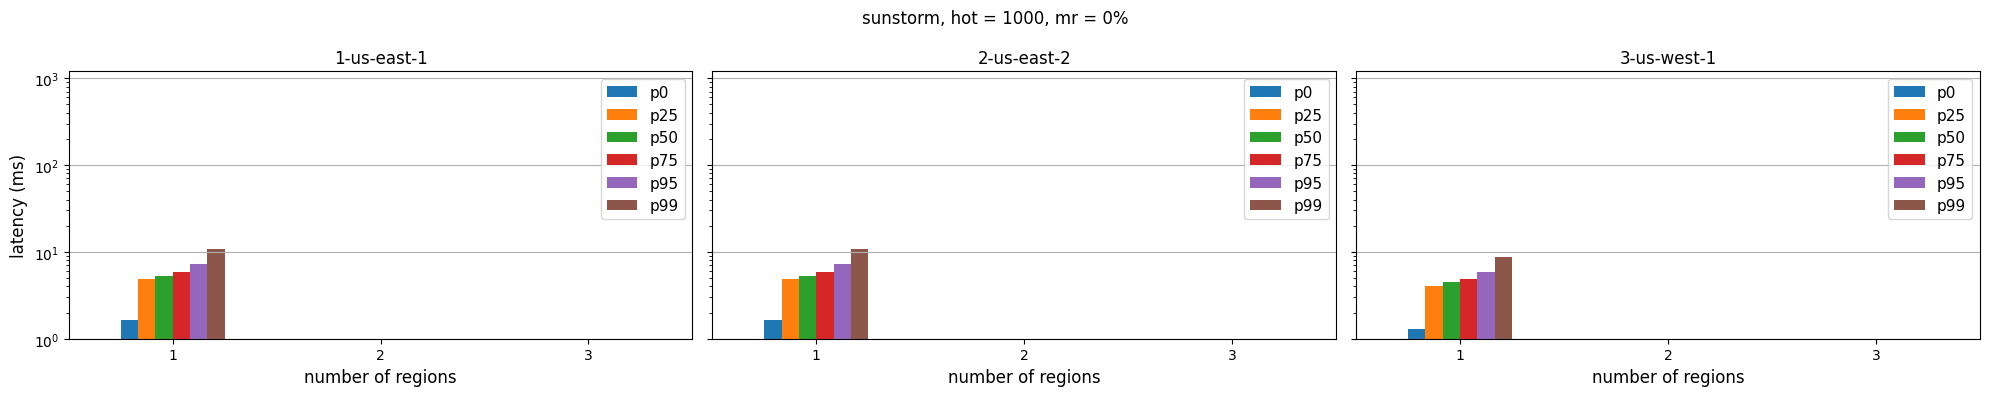

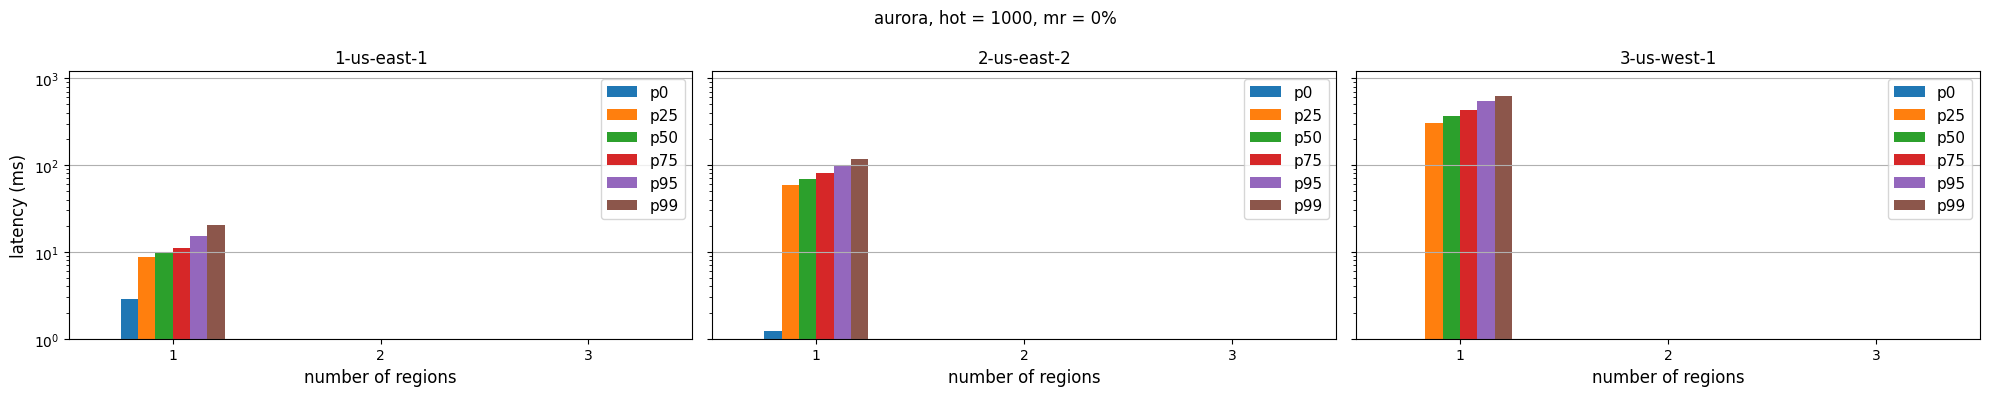

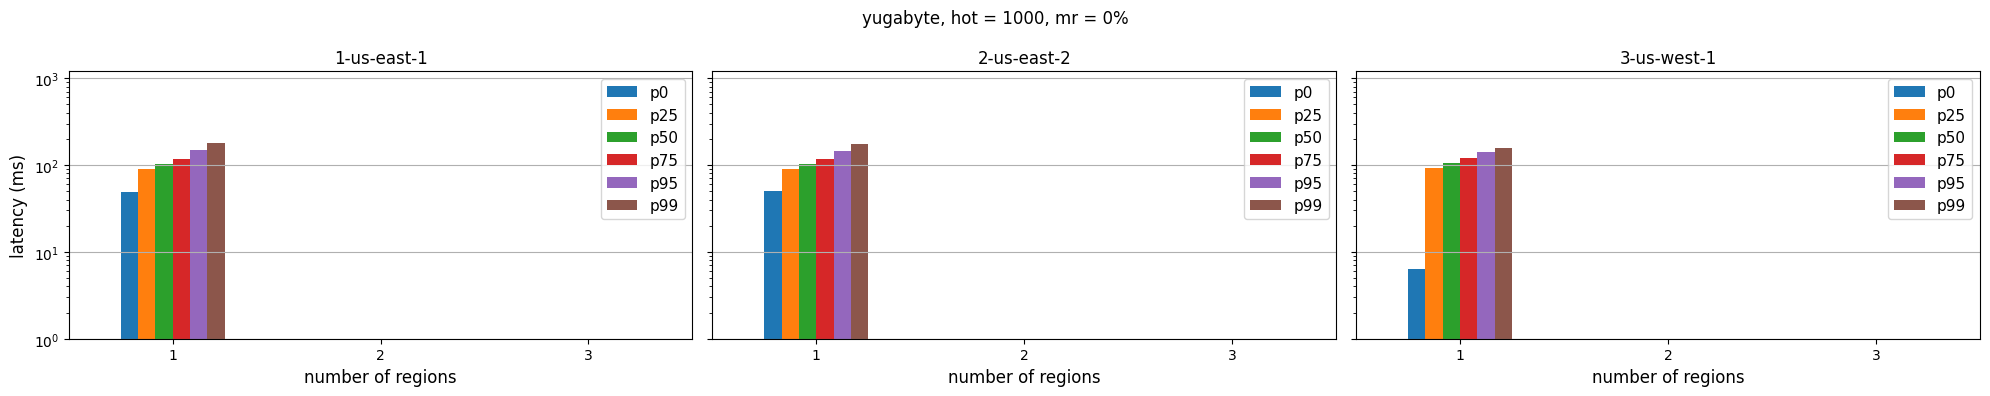

In [115]:
plot_latency(0, 1000)

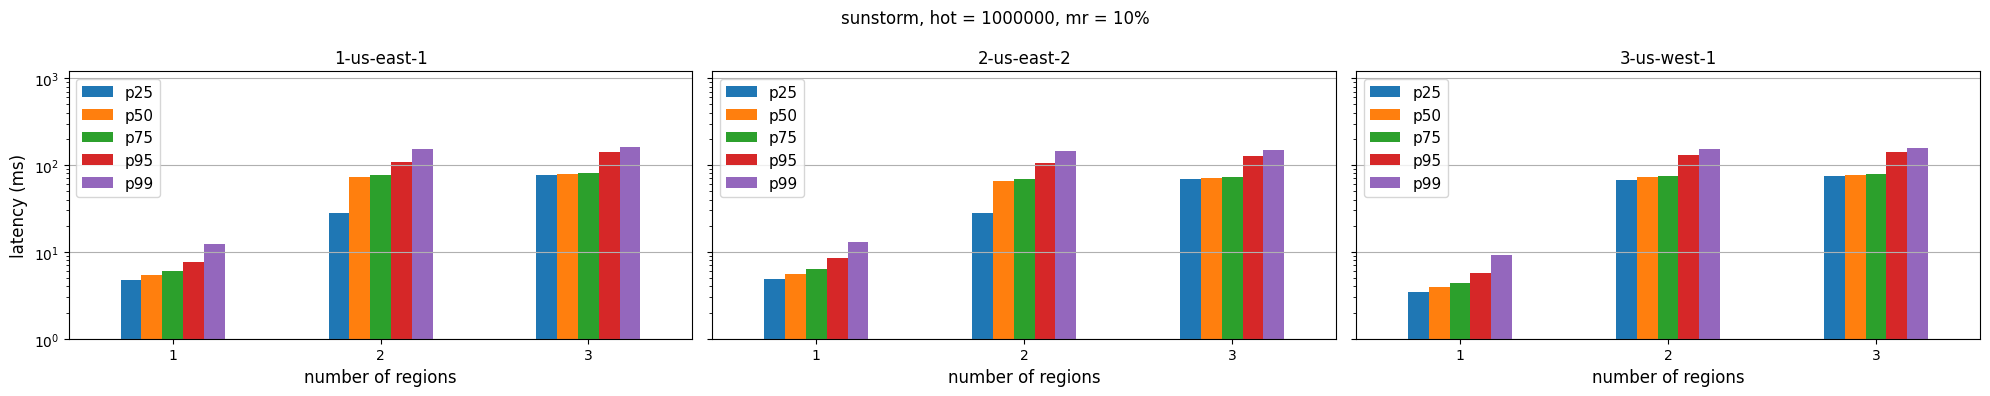

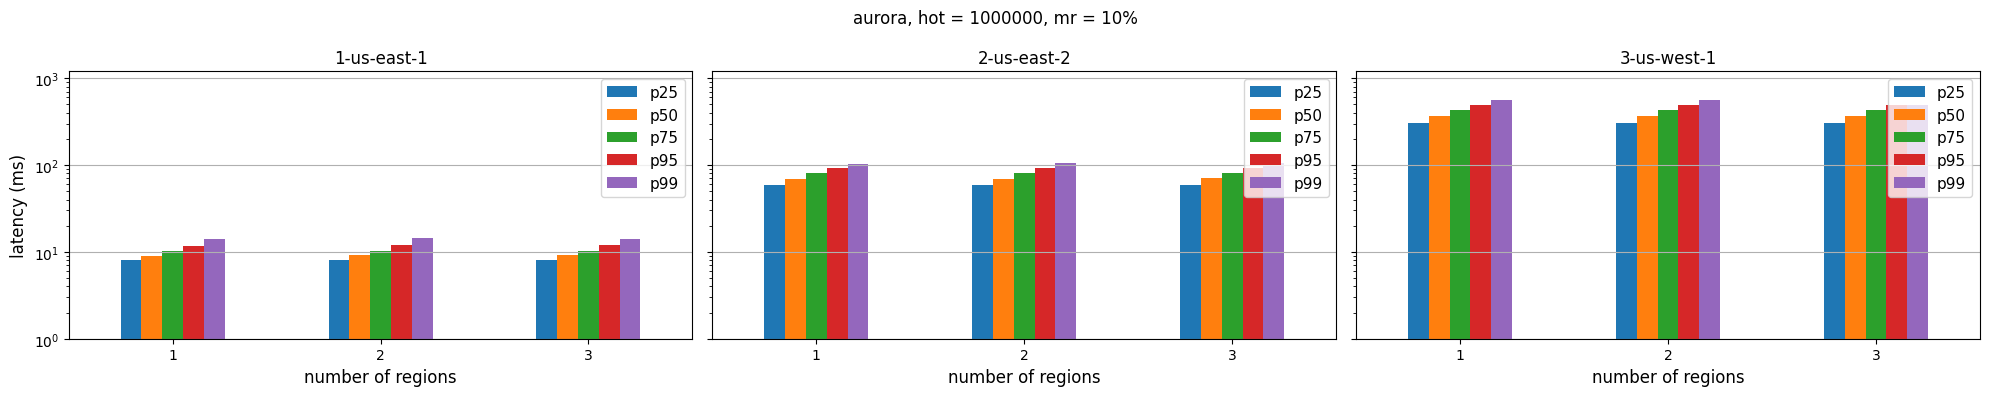

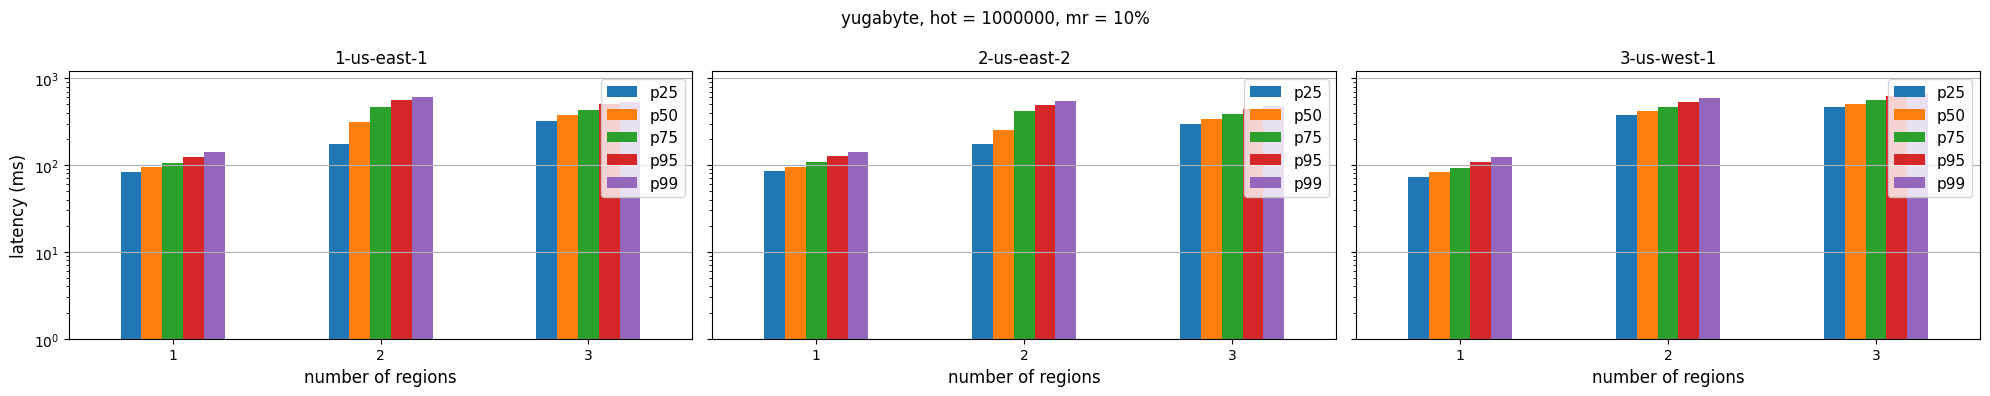

In [112]:
plot_latency(10, 1000000)

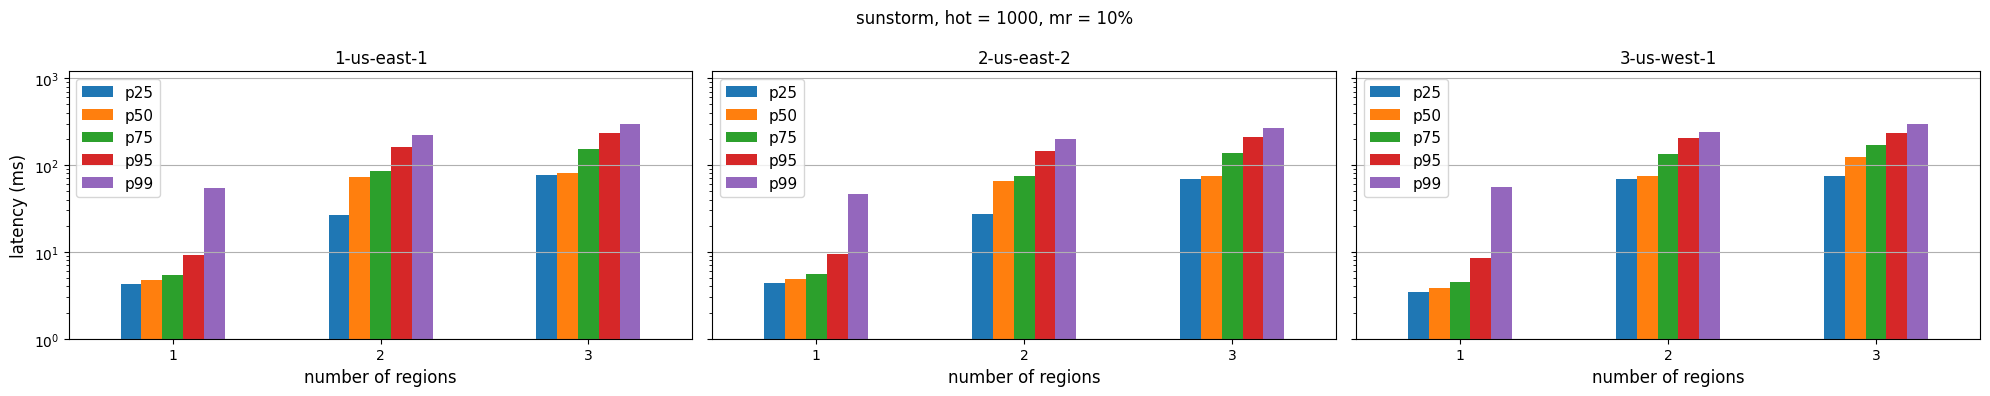

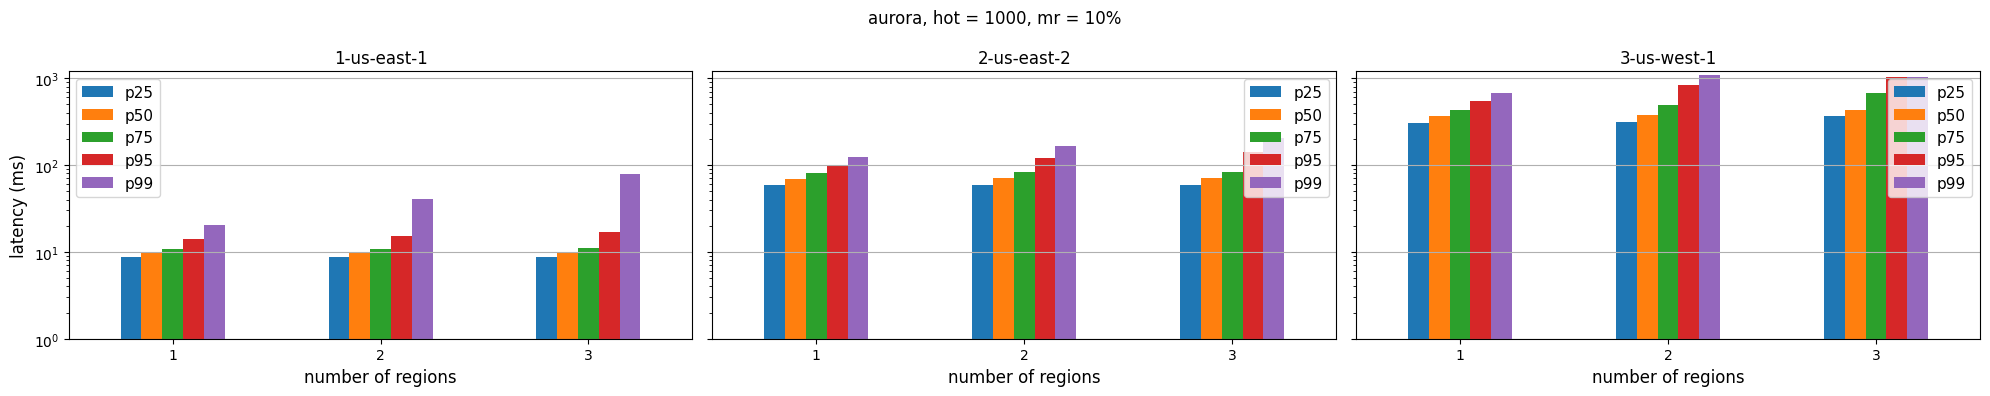

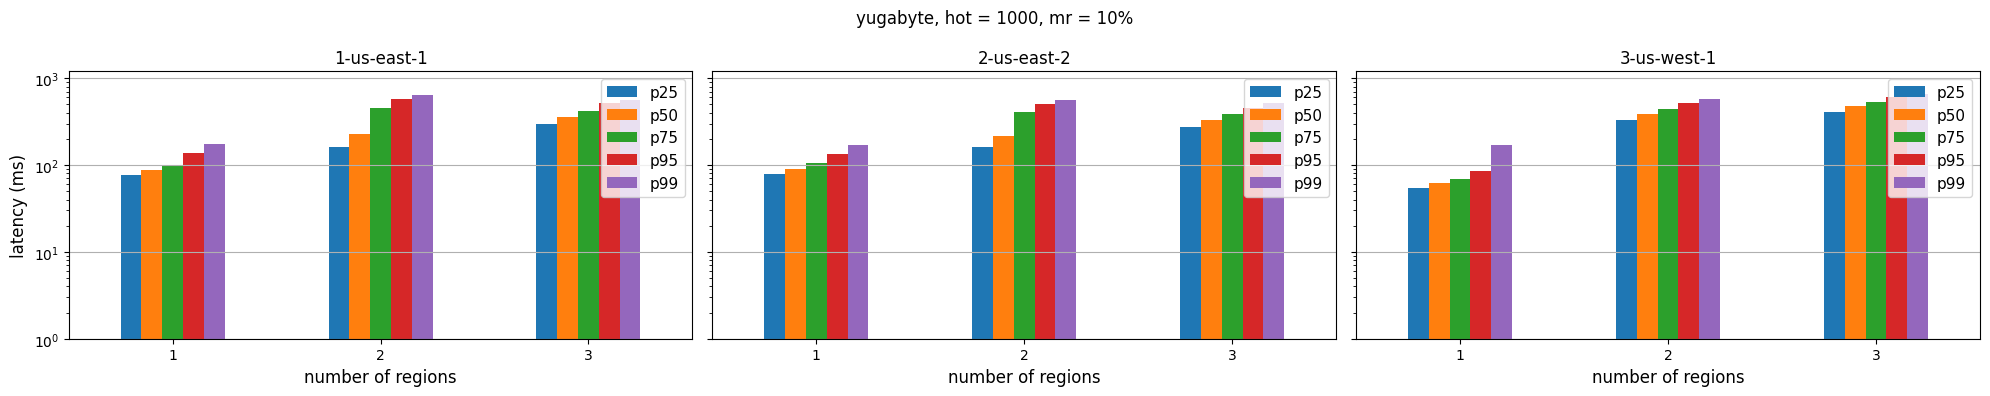

In [113]:
plot_latency(10, 1000)